<a href="https://colab.research.google.com/github/ericmassip/in_the_name_of_deep_learning/blob/master/frozen_encoder_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial configuration

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Reshape,Flatten,Dense,Dropout
from keras.models import Model
from keras import backend as K

from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)



1.13.1


In [0]:
from google.colab import drive, files
drive.mount('/content/drive/')
path = "drive/My Drive/KU_LEUVEN/CV/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

# Data

1.   Load data
2.   Load pre-trained autoencoder
3.   Reshape for the convolutional layer
4.   Randomize data
5.   Check train and validation images and labels


In [0]:
image_size = 128
#x_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_train_gray_128.p', mode='rb'))
#x_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_train_gray_64.p', mode='rb'))
x_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_train_rgb_128.p', mode='rb'))
#x_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_train_rgb_64.p', mode='rb'))
#x_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_val_gray_128.p', mode='rb'))
#x_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_val_gray_64.p', mode='rb'))
x_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_val_rgb_128.p', mode='rb'))
#x_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/x_val_rgb_64.p', mode='rb'))
y_train = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/y_train.p', mode='rb'))
y_val = pickle.load(open(path + 'dataset/cats_motorbikes_bottles/y_val.p', mode='rb'))
# remove elements with two classes
#a = y_train[:,0]+y_train[:,1]
#y_train = y_train[a!=2]
#x_train = x_train[a!=2]
#a = y_val[:,0]+y_val[:,1]
#y_val = y_val[a!=2]
#x_val = x_val[a!=2]
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(657, 128, 128, 3)
(644, 128, 128, 3)
(657, 3)
(644, 3)


In [0]:
autoencoder = load_model(path +'best_autoencoder_rgb_128.h5')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
__________

In [0]:
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
#x_t_r = x_train[s].reshape(-1,image_size,image_size,1)
x_t_r = x_train[s].reshape(-1,image_size,image_size,3)
y_t_r = y_train[s]
s = np.arange(x_val.shape[0])
np.random.shuffle(s)
#x_v_r = x_val[s].reshape(-1,image_size,image_size,1)
x_v_r = x_val[s].reshape(-1,image_size,image_size,3)
y_v_r = y_val[s]
# mix 
x_t_r = np.concatenate((x_t_r, x_v_r[0:400,:,:,:]), axis=0)
y_t_r = np.concatenate((y_t_r, y_v_r[0:400,:]), axis=0)
x_v_r = x_v_r[400:x_v_r.shape[0]]
y_v_r = y_v_r[400:y_v_r.shape[0]]
print(x_t_r.shape)
print(x_v_r.shape)
print(y_t_r.shape)
print(y_v_r.shape)

(1057, 128, 128, 3)
(244, 128, 128, 3)
(1057, 3)
(244, 3)


Train image 1
Label [0 1 0]
Train image 50
Label [0 0 1]


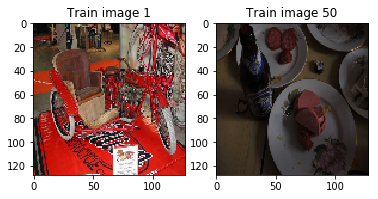

In [0]:
# Train image with label
plt.subplot(121)
img = 1
plt.imshow(x_t_r[img,:,:,:])
#plt.imshow(x_t_r[img,:,:,0],cmap='gray')
plt.title('Train image '+str(img))
print('Train image '+str(img))
print('Label '+str(y_t_r[img]))
plt.subplot(122)
img = 50
plt.imshow(x_t_r[img,:,:,:])
#plt.imshow(x_t_r[img,:,:,0],cmap='gray')
plt.title('Train image '+str(img))
print('Train image '+str(img))
print('Label '+str(y_t_r[img]))

Validation image 0
Label [1 0 0]
Validation image 50
Label [1 0 0]


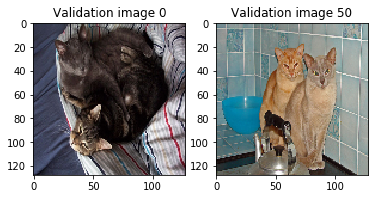

In [0]:
# Validation image with label
plt.subplot(121)
img = 0
plt.imshow(x_v_r[img,:,:,:])
#plt.imshow(x_v_r[img,:,:,0],cmap='gray')
plt.title('Validation image '+str(img))
print('Validation image '+str(img))
print('Label '+str(y_v_r[img]))
plt.subplot(122)
img = 50
plt.imshow(x_v_r[img,:,:,:])
#plt.imshow(x_v_r[img,:,:,0],cmap='gray')
plt.title('Validation image '+str(img))
print('Validation image '+str(img))
print('Label '+str(y_v_r[img]))

# Classifier with frozen encoder


*   sigmoid
*   binary_crossentropy


In [0]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv2d_44').output)

for layer in encoder.layers:
    layer.trainable = False

flat1 = Flatten()(encoder.output)
dense1 = Dense(3, activation='sigmoid')(flat1)
classifier = Model(inputs=encoder.input, outputs=dense1)

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
__________

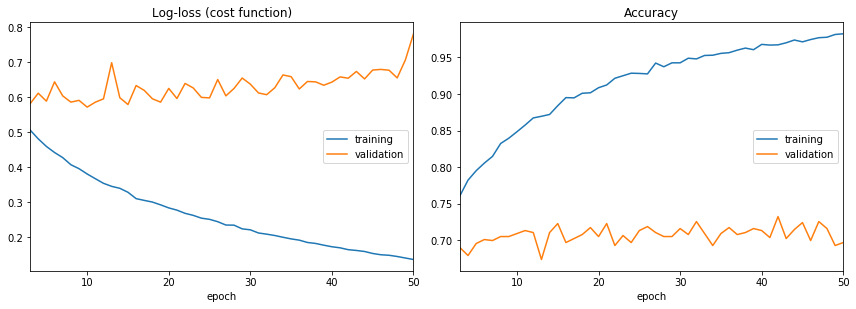

Log-loss (cost function):
training   (min:    0.136, max:    0.594, cur:    0.136)
validation (min:    0.571, max:    0.781, cur:    0.781)

Accuracy:
training   (min:    0.685, max:    0.982, cur:    0.982)
validation (min:    0.673, max:    0.732, cur:    0.697)


In [0]:
classifier.compile(loss='binary_crossentropy', 
                   optimizer = 'rmsprop', 
                   metrics=['accuracy'])

# accuracy = K.mean(K.equal(y_true,K.round(y_pred)))

classifier.fit(x_t_r, 
               y_t_r, 
               epochs=50,
               verbose=1,
               validation_data=(x_v_r, y_v_r),
               callbacks=[PlotLossesKeras()])

# Output frozen encoder


In [0]:
prob = classifier.predict(x_v_r)
thresh = 0.5
true_thresh = prob>=thresh;
false_thresh = prob<thresh;
prob[true_thresh]=1;
prob[false_thresh]=0;
acc = accuracy_score(y_v_r, prob)
# accuracy_score -> percentage of exactly matches 
print('Accuracy value = '+str(acc))

Accuracy value = 0.4139344262295082


Image 0
Label [1 0 0]
Target [1. 0. 0.]
Image 200
Label [1 0 0]
Target [0. 1. 0.]


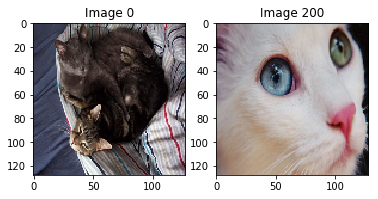

In [0]:
plt.subplot(121)
img = 0
plt.imshow(x_v_r[img,:,:,:])
#plt.imshow(x_v_r[img,:,:,0],cmap='gray')
plt.title('Image '+str(img))
print('Image '+str(img))
print('Label '+str(y_v_r[img]))
print('Target '+str(prob[img]))

plt.subplot(122)
img = 200
plt.imshow(x_v_r[img,:,:,:])
#plt.imshow(x_v_r[img,:,:,0],cmap='gray')
plt.title('Image '+str(img))
print('Image '+str(img))
print('Label '+str(y_v_r[img]))
print('Target '+str(prob[img]))